In [1]:
import numpy as np
import copy as cp
import matplotlib as mt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib.pyplot as plt
import pyemma.plots as mplt 
import pyemma
import pickle as pkl
import sklearn as skl
import sklearn.metrics as mtr
import scipy as sc
import sys
from tqdm import tqdm

In [2]:
sys.path.append('../0_python_modules/')

In [3]:
import proximity_matrix as pmt
import extras
import navjeet_hist as nh

In [4]:
randoms = np.loadtxt('../1_datasets/randoms.txt', dtype=int)

In [5]:
dists = [
    np.loadtxt(f'traj_specific_data/distances{i}.xvg', comments=['@','#'], usecols=[3]) for i in [0,4,3]
]

weights = np.array([
    np.where(i < 0.6)[0].shape[0] / i.shape[0] for i in dists
])

In [6]:
weights

array([0.06585091, 0.15872218, 0.06931373])

In [7]:
tlags = np.array([ 10, 20, 30, 50, 70, 100, 150, 200, 250, 350, 500, 700, 1000, 1500, 2000 ])

In [9]:
hdirect = []
edirect = []
for t in tlags:
    hdirect.append(np.load(f'saved_direct/tlag_{t}_hist.npy'))
    edirect.append(np.load(f'saved_direct/tlag_{t}_extents.npy'))

In [10]:
hsupervised = []
esupervised = []
for i in range(len(randoms)):
    hh = []
    ee = []
    for t in tlags:
        hh.append( np.load(f'saved_supervised/tlags/hist_{i}_{t}.npy') )
        ee.append( np.load(f'saved_supervised/tlags/extents_{i}_{t}.npy') )
    hsupervised.append(hh)
    esupervised.append(ee)

In [8]:
hpermute = []
epermute = []
for h in range(2,11):
    hhh=[]
    eee = []
    for i in range(len(randoms)):
        hh = []
        ee=[]
        for t in tlags:
            hh.append( np.load(f'saved_furf/tlags/hist_{h}_{i}_{t}.npy') )
            ee.append( np.load(f'saved_furf/tlags/extents_{h}_{i}_{t}.npy') )
        hhh.append(hh)
        eee.append(ee)
    hpermute.append(hhh)
    epermute.append(eee)

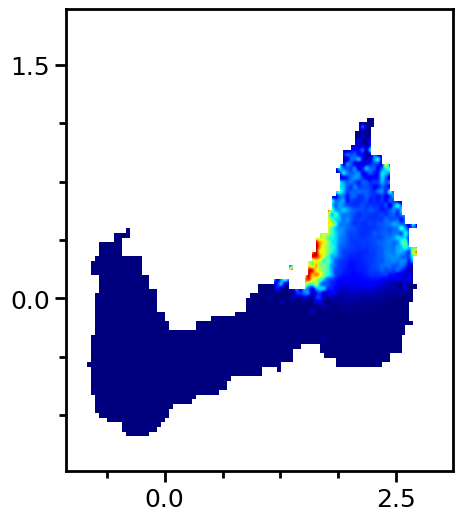

In [12]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
t, i = -4, 0
ax.imshow(hdirect[t][i].T, 
          aspect='auto', extent=edirect[t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/direct.png', transparent=True)
plt.show()

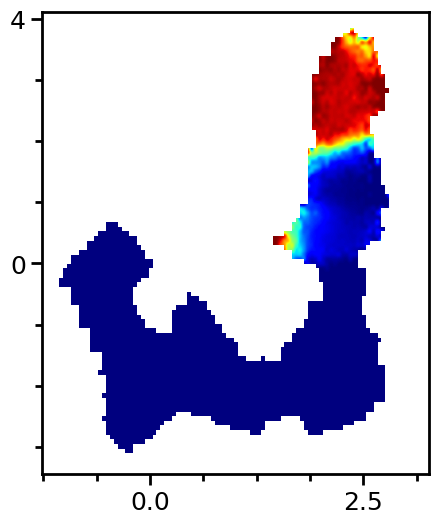

In [13]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
r, t, i = 0, -4, 0
ax.imshow(hsupervised[r][t][i].T, 
          aspect='auto', extent=esupervised[r][t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/supervised.png', transparent=True)

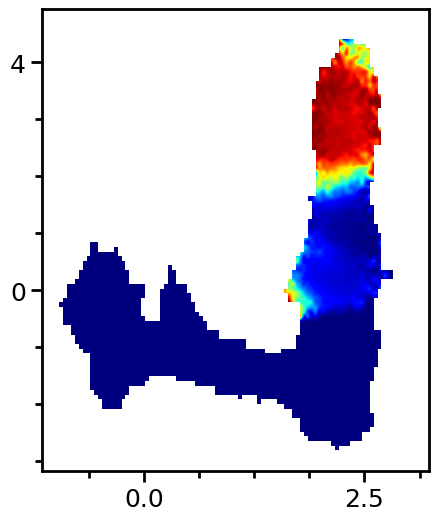

In [15]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
h, r, t, i = 0, 0, -4, 0
ax.imshow(hpermute[h][r][t][i].T, 
          aspect='auto', extent=epermute[h][r][t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/urf.png', transparent=True)

# parameters optimization

In [130]:
cmap = mt.cm.get_cmap('Reds')

In [131]:
tl = -4

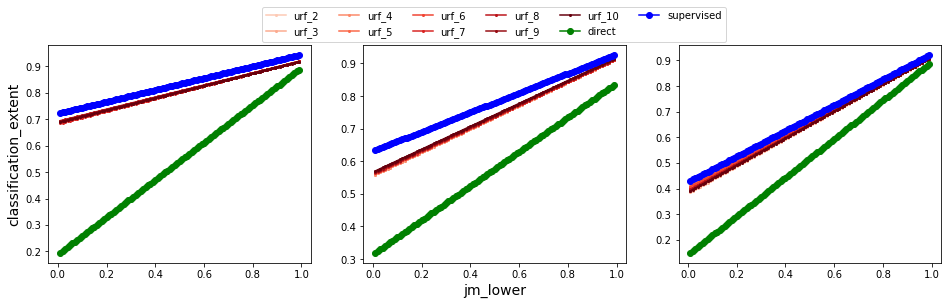

In [16]:
jm_lowers = np.arange(0.01,1,0.01)

cdirect = np.zeros((len(jm_lowers), len(dists)))
csupervised = np.zeros((len(jm_lowers), len(dists)))
cpermute = np.zeros((len(jm_lowers), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(jm_lowers)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=2, jm_lower=jm_lowers[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=2, jm_lower=jm_lowers[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=2, jm_lower=jm_lowers[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(jm_lowers, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(jm_lowers, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(jm_lowers, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('jm_lower', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

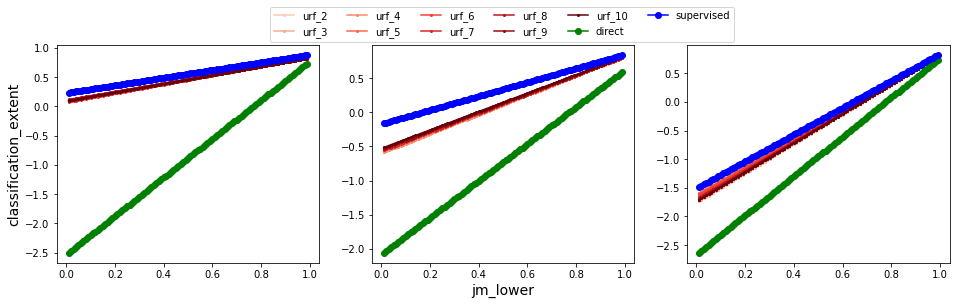

In [17]:
jm_lowers = np.arange(0.01,1,0.01)

cdirect = np.zeros((len(jm_lowers), len(dists)))
csupervised = np.zeros((len(jm_lowers), len(dists)))
cpermute = np.zeros((len(jm_lowers), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(jm_lowers)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=1, jm_lower=jm_lowers[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=1, jm_lower=jm_lowers[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=1, jm_lower=jm_lowers[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(jm_lowers, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(jm_lowers, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(jm_lowers, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('jm_lower', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

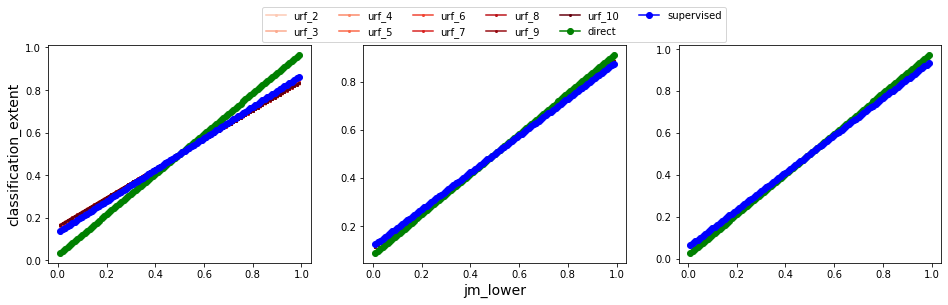

In [18]:
jm_lowers = np.arange(0.01,1,0.01)

cdirect = np.zeros((len(jm_lowers), len(dists)))
csupervised = np.zeros((len(jm_lowers), len(dists)))
cpermute = np.zeros((len(jm_lowers), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(jm_lowers)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=3, jm_lower=jm_lowers[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=3, jm_lower=jm_lowers[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=3, jm_lower=jm_lowers[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(jm_lowers, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(jm_lowers, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(jm_lowers, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('jm_lower', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

### same as idp, for rare state - lower value of jm_lower is required

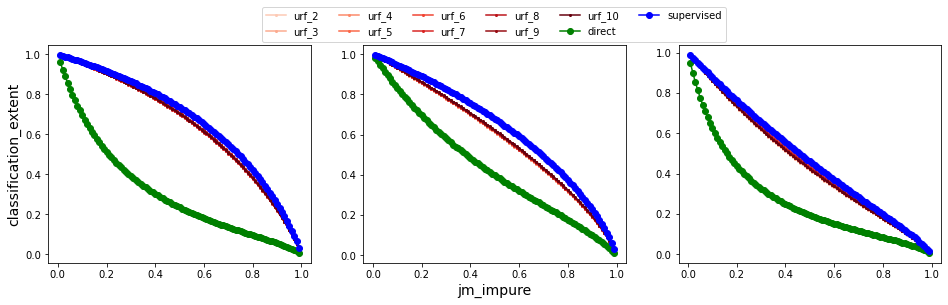

In [24]:
jm_impures = np.arange(0.01,1,0.01)

cdirect = np.zeros((len(jm_impures), len(dists)))
csupervised = np.zeros((len(jm_impures), len(dists)))
cpermute = np.zeros((len(jm_impures), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(jm_impures)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=2, jm_lower=weights[t], jm_impure=jm_impures[i], )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=2, jm_lower=weights[t], jm_impure=jm_impures[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=2, jm_lower=weights[t], jm_impure=jm_impures[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(jm_impures, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(jm_impures, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(jm_impures, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('jm_impure', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

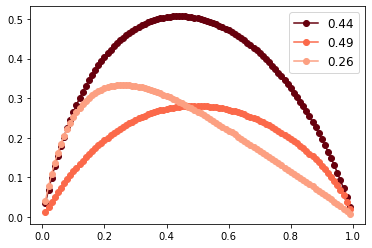

In [25]:
impures = np.zeros((3))
for t in range(len(dists)):
    diff = csupervised[:,t] - cdirect[:,t]
    im = jm_impures[diff.argmax()]
    impures[t] = im
    plt.plot(jm_impures, diff, '-o', color=cmap(1/(t+1)), label=str(im) )
plt.legend(fontsize=12)

### same as idp, best value for traj-1 is 0.44

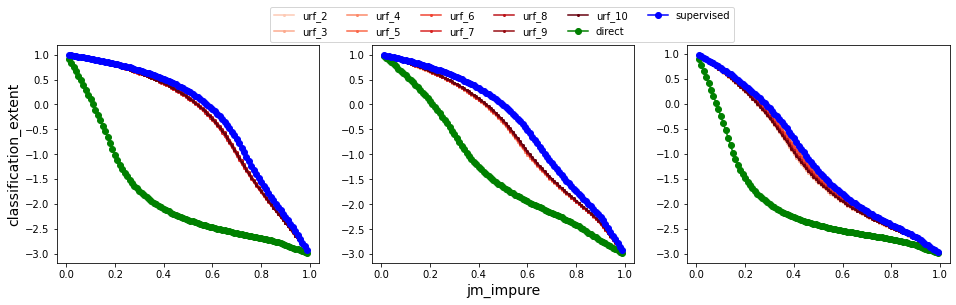

In [26]:
jm_impures = np.arange(0.01,1,0.01)

cdirect = np.zeros((len(jm_impures), len(dists)))
csupervised = np.zeros((len(jm_impures), len(dists)))
cpermute = np.zeros((len(jm_impures), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(jm_impures)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=1, jm_lower=weights[t], jm_impure=jm_impures[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=1, jm_lower=weights[t], jm_impure=jm_impures[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=1, jm_lower=weights[t], jm_impure=jm_impures[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(jm_impures, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(jm_impures, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(jm_impures, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('jm_impure', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

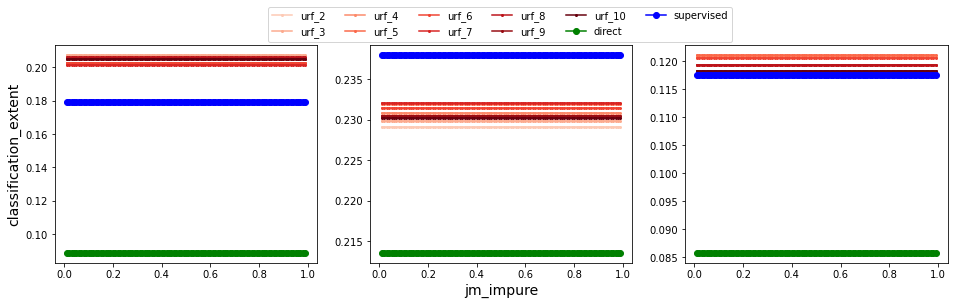

In [27]:
jm_impures = np.arange(0.01,1,0.01)

cdirect = np.zeros((len(jm_impures), len(dists)))
csupervised = np.zeros((len(jm_impures), len(dists)))
cpermute = np.zeros((len(jm_impures), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(jm_impures)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=3, jm_lower=weights[t], jm_impure=jm_impures[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=3, jm_lower=weights[t], jm_impure=jm_impures[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=3, jm_lower=weights[t], jm_impure=jm_impures[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(jm_impures, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(jm_impures, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(jm_impures, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('jm_impure', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

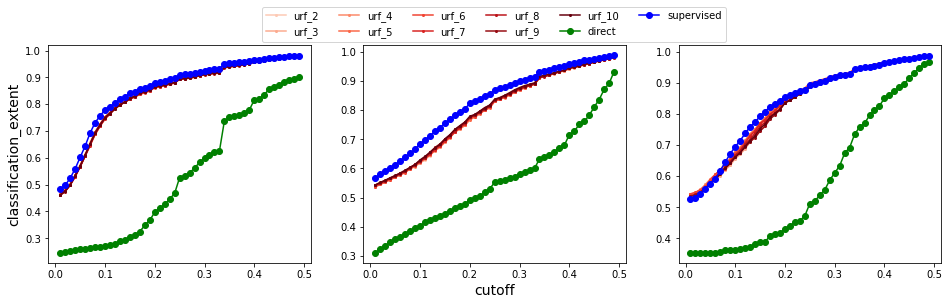

In [28]:
cutts = np.arange(0.01,0.5,0.01)

cdirect = np.zeros((len(cutts), len(dists)))
csupervised = np.zeros((len(cutts), len(dists)))
cpermute = np.zeros((len(cutts), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(cutts)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=2, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=2, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=2, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(cutts, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(cutts, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(cutts, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('cutoff', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

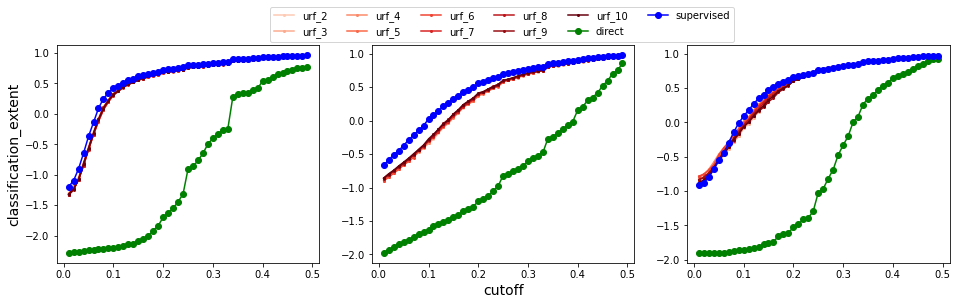

In [29]:
cutts = np.arange(0.01,0.5,0.01)

cdirect = np.zeros((len(cutts), len(dists)))
csupervised = np.zeros((len(cutts), len(dists)))
cpermute = np.zeros((len(cutts), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(cutts)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=1, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=1, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=1, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(cutts, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(cutts, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(cutts, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('cutoff', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

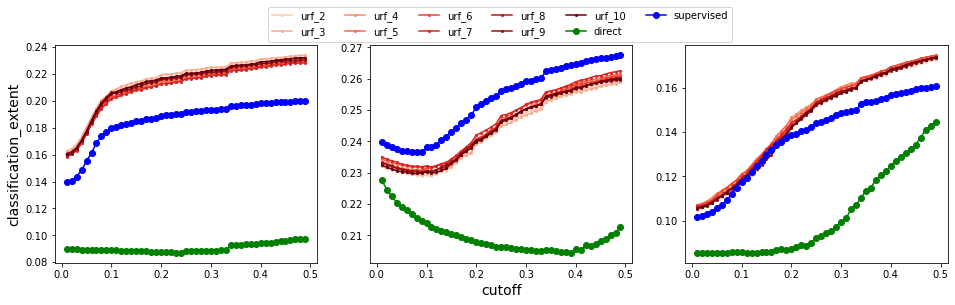

In [30]:
cutts = np.arange(0.01,0.5,0.01)

cdirect = np.zeros((len(cutts), len(dists)))
csupervised = np.zeros((len(cutts), len(dists)))
cpermute = np.zeros((len(cutts), 9, len(dists)))

for t in range(len(dists)):

    for i in range(len(cutts)):

        cdirect[i,t] = nh.classification_extent( hdirect[tl][t], output_type='jm', operation=3, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )

        cs = 0
        for r in range(len(randoms)):
            cs += nh.classification_extent( hsupervised[r][tl][t], output_type='jm', operation=3, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )
        csupervised[i,t] = cs/len(randoms)

        for h in range(2,11):
            cp = 0
            for r in range(len(randoms)):
                cp += nh.classification_extent( hpermute[h-2][r][tl][t], output_type='jm', operation=3, jm_lower=weights[t], jm_impure=impures[t], cutoff=cutts[i] )
            cpermute[i,h-2,t] = cp/len(randoms)
        
fig,ax=plt.subplots(1,3,figsize=(16,4))
for t in range(len(dists)):
    for h in range(2,11):
        ax[t].plot(cutts, cpermute[:,h-2,t], '-o', ms=2, color=cmap(h/10), label=f'urf_{h}')
    ax[t].plot(cutts, cdirect[:,t], '-o', color='green', label='direct')
    ax[t].plot(cutts, csupervised[:,t], '-o', color='blue', label='supervised')
    ax[1].set_xlabel('cutoff', fontsize=14)
    ax[0].set_ylabel('classification_extent', fontsize=14)
ax[1].legend(ncol=6, bbox_to_anchor=(1.4,1.2), loc=1)
plt.show()

# best parameters
## operation = jm type 2
## jm_lower = low values, based on weight of rare state
## jm_impure = 0.44 for traj-1
## cutoff = guess value of 0.1

In [11]:
cpermute

array([[0.75280844, 0.0074498 ],
       [0.75263555, 0.00516126],
       [0.74894902, 0.01252737],
       [0.74989398, 0.01625782],
       [0.74882839, 0.0153995 ],
       [0.74607373, 0.01594408],
       [0.75441044, 0.00955399],
       [0.75169198, 0.00730857],
       [0.75014402, 0.01048384]])

# final plots

In [10]:
t=0
tl=-4
impures = [0.44,0.49,0.26]

cdirect = nh.classification_extent( hdirect[tl][t], cutoff=0.1, strategy='weighted',
                                  output_type='jm', operation=2, jm_lower=weights[t], jm_impure=impures[t])

csupervised = []
for i in range(len(randoms)):
    csupervised.append( nh.classification_extent(hsupervised[i][tl][t], cutoff=0.1, strategy='weighted',
                                                output_type='jm', operation=2, jm_lower=weights[t], jm_impure=impures[t]) )
csupervised = [np.mean(csupervised), np.std(csupervised)]

cpermute = []
for h in hpermute:
    cp=[]
    for i in h:
        cp.append( nh.classification_extent( i[tl][t], cutoff=0.1, strategy='weighted',
                                           output_type='jm', operation=2, jm_lower=weights[t], jm_impure=impures[t]) )
    cpermute.append( [np.mean(cp), np.std(cp)] )
cpermute = np.array(cpermute)

t=0
tl=-4
impures = [0.44,0.49,0.26]

cdirect = nh.classification_extent( 1-hdirect[tl][t], cutoff=0.1, strategy='weighted',
                                  output_type='jm', operation=2, jm_lower=1-weights[t], jm_impure=impures[t])

csupervised = []
for i in range(len(randoms)):
    csupervised.append( nh.classification_extent(1-hsupervised[i][tl][t], cutoff=0.1, strategy='weighted',
                                                output_type='jm', operation=2, jm_lower=1-weights[t], jm_impure=impures[t]) )
csupervised = [np.mean(csupervised), np.std(csupervised)]

cpermute = []
for h in hpermute:
    cp=[]
    for i in h:
        cp.append( nh.classification_extent( 1-i[tl][t], cutoff=0.1, strategy='weighted',
                                           output_type='jm', operation=2, jm_lower=1-weights[t], jm_impure=impures[t]) )
    cpermute.append( [np.mean(cp), np.std(cp)] )
cpermute = np.array(cpermute)

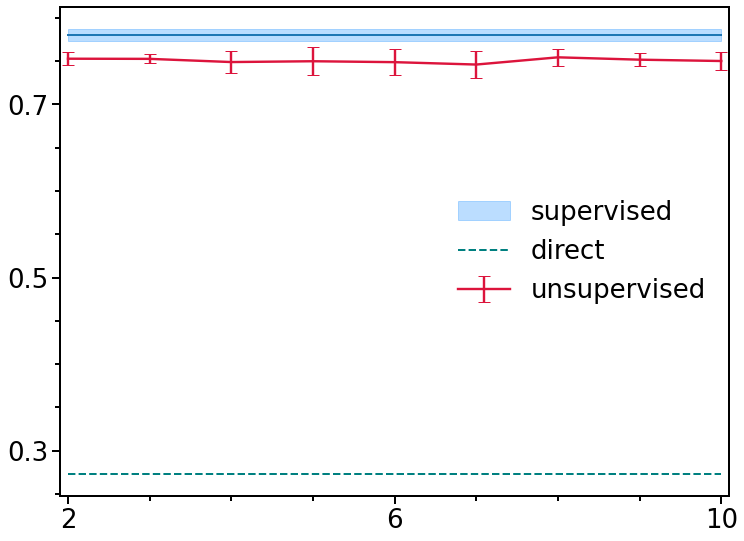

In [195]:
fig,ax=plt.subplots(1,figsize=(12,9))
ax.fill_between([2,10], csupervised[0]+csupervised[1], csupervised[0]-csupervised[1], color='dodgerblue', alpha=0.3, label='supervised')
ax.plot([2,10], [csupervised[0], csupervised[0]], lw=2)
ax.plot([2,10], [cdirect, cdirect], '--', color='teal', lw=2, label='direct')
ax.errorbar(range(2,11), cpermute[:,0], yerr=cpermute[:,1], ecolor='crimson', color='crimson', capsize=6, lw=2.4, label='unsupervised')
#
ax.spines[:].set_linewidth(2)
ax.tick_params(labelsize=26, length=8, width=2)
ax.set_xticks([2,6,10])
ax.set_yticks([0.3, 0.5, 0.7])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(which='minor', length=5, width=2)
ax.set_xlim(1.9,10.1)

leg=plt.legend(fontsize=26)
leg.get_frame().set_alpha(0)

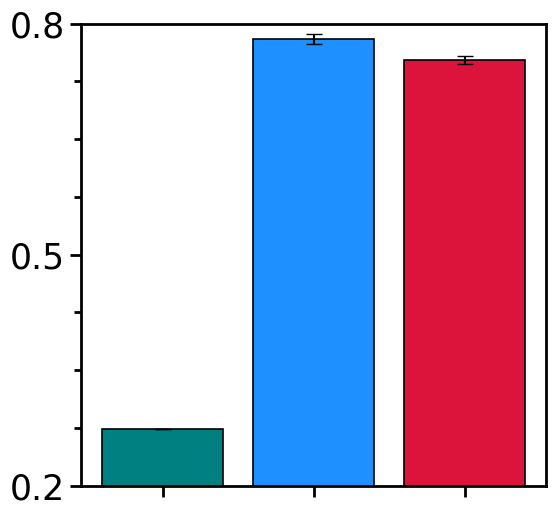

In [24]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.bar([0,1,2], [cdirect, csupervised[0], cpermute[1,0]], yerr=[0, csupervised[1], cpermute[1,1]],
      color=['teal', 'dodgerblue','crimson'], edgecolor='black', linewidth=1.2, capsize=6 )
ax.spines[:].set_linewidth(2)
ax.set_ylim(0.2,0.8)
ax.set_yticks([0.2,0.5,0.8])
ax.set_xticks([0,1,2])
ax.tick_params(length=8, width=2, labelsize=25, labelbottom=False)
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(which='minor', length=5, width=2)
plt.savefig('plots/ce.png', transparent=True)

In [20]:
tlags = np.array([ 10, 20, 30, 50, 70, 100, 150, 200, 250, 350, 500, 700, 1000, 1500, 2000 ])
t = 0
jm_impures = [0.44, 0.49, 0.26]

cdirect = np.zeros(( len(tlags) ))
csupervised = np.zeros(( len(tlags), 2 ))
cpermute = np.zeros(( 9, len(tlags), 2 ))

for tl in range(len(tlags)):
    
    cdirect[tl] = nh.classification_extent( hdirect[tl][t], cutoff=0.1, strategy='weighted',
                                            output_type='jm', jm_lower=weights[t], jm_impure=jm_impures[t], 
                                            operation=2 ) 
    
    cc = []
    for i in range(len(randoms)):
        cc.append( nh.classification_extent( hsupervised[i][tl][t], cutoff=0.1, strategy='weighted', 
                                           output_type='jm', jm_lower=weights[t], jm_impure=jm_impures[t],
                                           operation=2) )
    csupervised[tl] = [ np.mean(cc), np.std(cc) ]
    
    for h in range(2,11):
        cc = []
        for i in range(len(randoms)):
            cc.append( nh.classification_extent( hpermute[h-2][i][tl][t], cutoff=0.1, strategy='weighted',
                                               output_type='jm', jm_lower=weights[t], jm_impure=jm_impures[t],
                                               operation=2 ) )
        cpermute[h-2][tl] = [ np.mean(cc), np.std(cc) ]

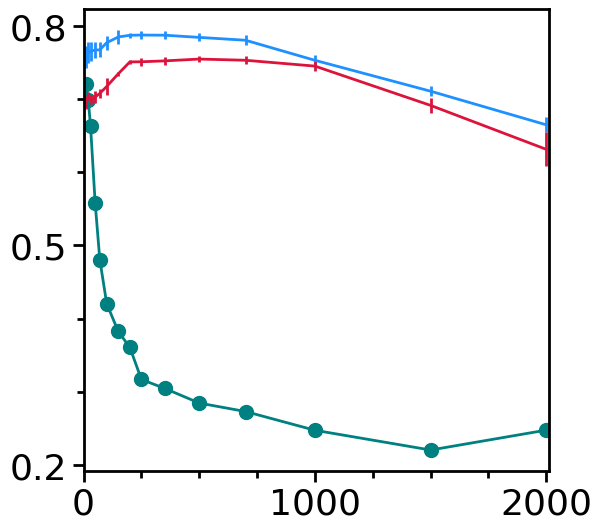

In [22]:
fig,ax=plt.subplots(1,figsize=(5,6))

ax.plot(tlags, cdirect, '-o', color='teal', lw=2, label='direct', markersize=10)
ax.errorbar( tlags, csupervised[:,0], yerr=csupervised[:,1], lw=2, color='dodgerblue', label='supervised' )
ax.errorbar( tlags, cpermute[1][:,0], yerr=cpermute[1][:,1], lw=2, color='crimson',label='urf' )
    
ax.spines[:].set_linewidth(2)
ax.tick_params(labelsize=26, length=8, width=2)
ax.set_xticks([0,1000, 2000])
ax.set_yticks([0.2, 0.5, 0.8])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))
ax.tick_params(which='minor', length=5, width=2)
ax.set_xlim(0,2010)

plt.savefig('plots/ce_tlags.png', transparent=True)
plt.show()

# other_plots

## fes

In [25]:
tic2 = np.load('traj_specific_data/tic2_700_supervised0.npy')

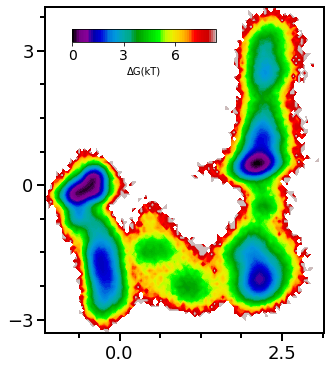

In [26]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
cax = fig.add_axes([0.2,0.8,0.4,0.03])
mplt.plot_free_energy(tic2[:,0], tic2[:,1], 
                      ax=ax, cax=cax, cbar_orientation='horizontal', cbar_label=u'\u0394G(kT)')
cax.xaxis.set_major_locator(mt.ticker.MaxNLocator(3))
cax.tick_params(labelsize=14)

plt.savefig('plots/fes_supervised0.pdf')
plt.show()

## other states

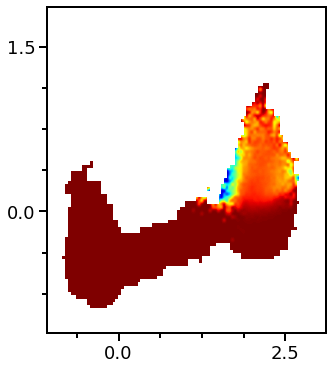

In [98]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
t, i = -4, 0
ax.imshow( (1-hdirect[t][i]).T, 
          aspect='auto', extent=edirect[t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/unbound_direct.pdf')
plt.show()

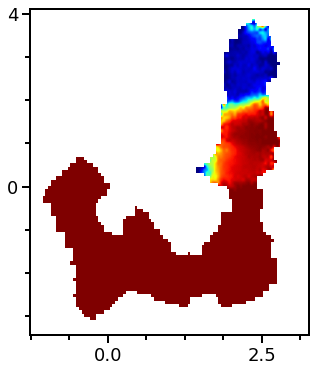

In [99]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
r, t, i = 0, -4, 0
ax.imshow( (1-hsupervised[r][t][i]).T, 
          aspect='auto', extent=esupervised[r][t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/unbound_supervised.pdf')

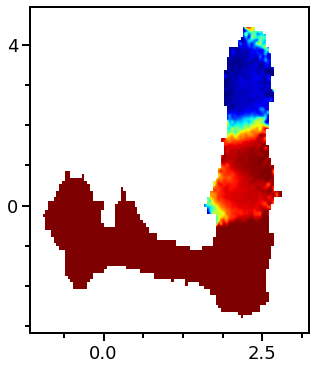

In [101]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
h, r, t, i = 0, 0, -4, 0
ax.imshow( (1-hpermute[h][r][t][i]).T, 
          aspect='auto', extent=epermute[h][r][t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/unbound_urf.pdf')

## other trajs

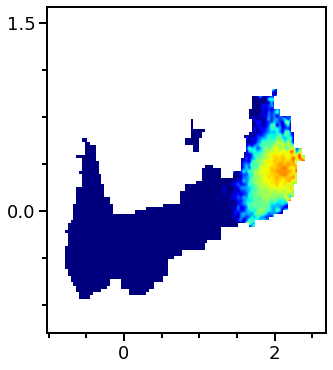

In [106]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
t, i = -4, 2
ax.imshow(hdirect[t][i].T, 
          aspect='auto', extent=edirect[t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/direct_traj{i+1}.pdf')
plt.show()

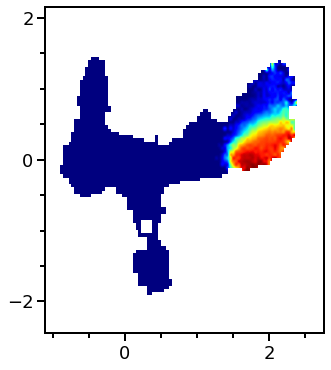

In [108]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
r, t, i = 0, -4, 2
ax.imshow(hsupervised[r][t][i].T, 
          aspect='auto', extent=esupervised[r][t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/supervised_traj{i+1}.pdf')

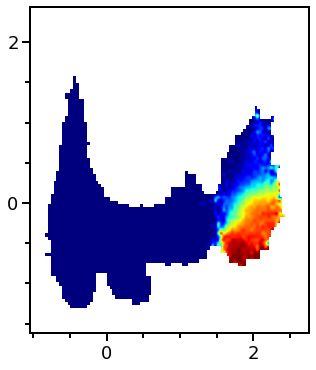

In [110]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(2))
ax.tick_params(which='minor', length=5, width=2)
h, r, t, i = 0, 0, -4, 2
ax.imshow(hpermute[h][r][t][i].T, 
          aspect='auto', extent=epermute[h][r][t][i], origin='lower', interpolation='gaussian',
          cmap='jet', vmin=0, vmax=1)
plt.savefig(f'plots/urf_traj{i+1}.pdf')

## fimp

In [119]:
fimp1 = [np.load(f'saved_supervised/fimp_supervised_{i}.npy') for i in range(5)]
fimp1 = [ np.cumsum( i[i.argsort()[::-1]] ) for i in fimp1 ]
fimp1 = np.mean(fimp1, axis=0), np.std(fimp1, axis=0)

In [120]:
fimp2 = [np.load(f'saved_furf/fimp_hlabel2_{i}.npy') for i in range(5)]
fimp2 = [ np.cumsum( i[i.argsort()[::-1]] ) for i in fimp2 ]
fimp2 = np.mean(fimp2, axis=0), np.std(fimp2, axis=0)

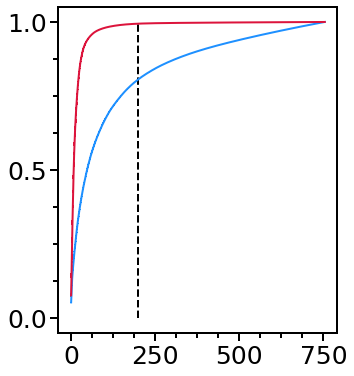

In [216]:
fig,ax = plt.subplots(1,figsize=(5,6))
ax.spines[:].set_linewidth(2)
ax.tick_params(length=8, width=2, labelsize=25)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_yticks([0,0.5,1])
ax.xaxis.set_major_locator(mt.ticker.MaxNLocator(4))
ax.tick_params(which='minor', length=5, width=2)
ax.errorbar(range(len(fimp1[0])), fimp1[0], yerr=fimp1[1], c='dodgerblue', lw=2)
ax.errorbar(range(len(fimp2[0])), fimp2[0], yerr=fimp2[1], c='crimson', lw=2)
ax.plot([200,200],[0,1],'--', c='black', lw=2)

plt.savefig(f'plots/fimp_cumsum.pdf')

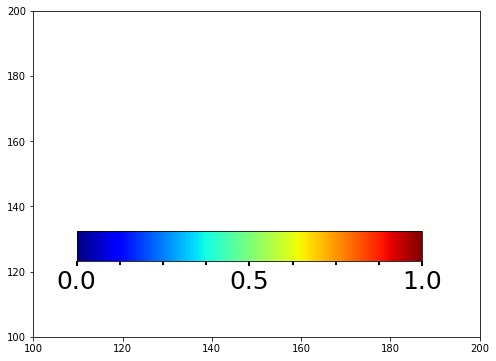

In [246]:
fig,ax = plt.subplots(1,figsize=(8,6))
cax = fig.add_axes([0.2,0.3,0.6,0.07])
t, i = -4, 2
pl=ax.imshow(hdirect[t][i].T, 
          aspect='auto',
          cmap='jet', vmin=0, vmax=1)
ax.set_xlim([100,200])
ax.set_ylim([100,200])
cb=plt.colorbar(pl, cax=cax, orientation='horizontal')
cb.ax.set_xticks([0,0.5,1])
cb.ax.tick_params(length=5, width=2, labelsize=25)
cb.ax.xaxis.set_minor_locator(AutoMinorLocator(4))
cb.ax.tick_params(which='minor', length=4, width=2)
plt.savefig(f'plots/colorbar.pdf')
plt.show()

In [8]:
hvamp = np.load('saved_vamp/hists.npy')
evamp = np.load('saved_vamp/extents.npy')

In [9]:
hvamp.shape

(6, 3, 100, 100)

In [10]:
impures = [0.44,0.49,0.26]

In [28]:
t=0

cvamp = [ nh.classification_extent( i[t], cutoff=0.1, strategy='weighted',
                                  output_type='jm', operation=2, jm_lower=weights[t], jm_impure=impures[t])
        for i in hvamp]
cvamp = np.mean(cvamp), np.std(cvamp)
cvamp

(0.6226228975916851, 0.25331630649607706)

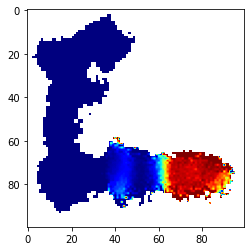

In [20]:
plt.imshow(hvamp[5][0], cmap='jet', vmin=0, vmax=1)